In [4]:
import numpy as np
import DataProcess as DP
import FeatureCalculate as FC
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler

In [2]:
def preprocess(subjectID, redact=1000, rescale=False):
    subj_filename = './PAMAP2_Dataset/Protocol/subject10'+str(subjectID)+'.dat'
    col_labels = DP.col_labels
    col_sublabels = DP.col_sublabels
    HR_lim = DP.HR_lim
    HR_rest = HR_lim[subjectID][0]
    HR_max = HR_lim[subjectID][1]
    X_std = np.empty(0)
    
    #generate dataframe from the raw data
    data=pd.read_csv(subj_filename,sep=' ',names=col_labels,header=None)

    #linear interpolate missing data
    data=data.interpolate(method='linear')

    #drop columns for orientation and acc6g
    data=pd.DataFrame(data,columns=col_sublabels)

    #convert to array
    data=np.array(data)

    #normalize heart rate
    data[:,2]=DP.HR_norm(data[:,2],HR_rest,HR_max)
    
    #Rescale:
    if rescale:
        SS = StandardScaler(copy=True, with_mean=True, with_std=True)
        data[:, 3:] = SS.fit_transform(data[:, 3:])
        X_std = np.copy(data[:, 3:])
        
    #computes timestamp indices where the activity changes, including 0 and l
    l=len(data)
    r=np.arange(l-1)+1
    split_ind=r[data[r,1]!=data[r-1,1]]
    split_ind=np.concatenate(([0],split_ind,[l]))

    #chop data into chunks of continuous time blocks with the same activity, also remove activity zero
    chunks=[data[split_ind[i]:split_ind[i+1]] for i in range(len(split_ind)-1) if data[split_ind[i],1]!=0]
        
    #drop the first and last n samples. Only keep redacted samples that 
    #are of sufficient length
        
    chunks=[x[redact:-(redact+1)] for x in chunks if len(x) > (2*redact)]

    return X_std, chunks


def raw_segmentation(chunks,T=512,stride=512):
    data_segmented=[]
    for chunk in chunks:
        imax=(len(chunk)-T)//stride
        for i in range(imax+1):
            arr = chunk[i*stride:i*stride+T]
            data_segmented.append(arr)
    return np.array(data_segmented)


def segmentation(chunks,T=512,stride=512):
    data_segmented=[]
    for chunk in chunks:
        imax=(len(chunk)-T)//stride
        for i in range(imax+1):
            arr = chunk[i*stride:i*stride+T]
            rawarr = arr[:, 2:].flatten('F')
            farr = feature_extraction(arr)
            totalarr = np.append(rawarr, farr)
            data_segmented.append(totalarr)
    return np.array(data_segmented)


def feature_extraction(segment):
    fc = FC.FeatureCalc()
        
    segment_df=pd.DataFrame(segment,columns=DP.col_sublabels)
    fc.load_new_ts(segment_df)
    arr=fc.calculate_features()
    return arr

### Raw + feature data

In [5]:
specchunks=[]
for i in DP.protocol_list:
    X_std, specchunk = preprocess(i, 1000, rescale=True)
    specchunks.append(np.array(specchunk))

In [6]:
chunks=[]
for i in range(len(specchunks)):
    chunks.append(segmentation(specchunks[i],T=400,stride=400))

In [7]:
print("length of one data point should be: 31*(400+4)+1=", 31*(400+4)+1)
print("Shape of chunks from subjects:")
for i in range(len(chunks)):
    print(chunks[i].shape)

length of one data point should be: 31*(400+4)+1= 12525
Shape of chunks from subjects:
(547, 12525)
(581, 12525)
(375, 12525)
(512, 12525)
(606, 12525)
(553, 12525)
(510, 12525)
(579, 12525)
(10, 12525)


#### Train-test splitting

In [8]:
# Stack data from different subjects into one chunk:
data = np.vstack(chunks)

#shuffle data
np.random.shuffle(data)

X = data[:,:-1]
y = data[:,-1]

In [9]:
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Raw data only:

In [73]:
rawspecchunks=[]
for i in DP.protocol_list:
    X_std, specchunk = preprocess(i, 1000, rescale=False)
    rawspecchunks.append(np.array(specchunk))

In [74]:
rawchunks=[]
for i in range(len(rawspecchunks)):
    rawchunks.append(raw_segmentation(rawspecchunks[i],T=400,stride=400))

In [143]:
# Normalize raw data
rawnormchunks=[]
for i in range(len(specchunks)):
    rawnormchunks.append(raw_segmentation(specchunks[i],T=400,stride=400))

#### Recurrence plot:

In [125]:
from sklearn.metrics import pairwise

def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d

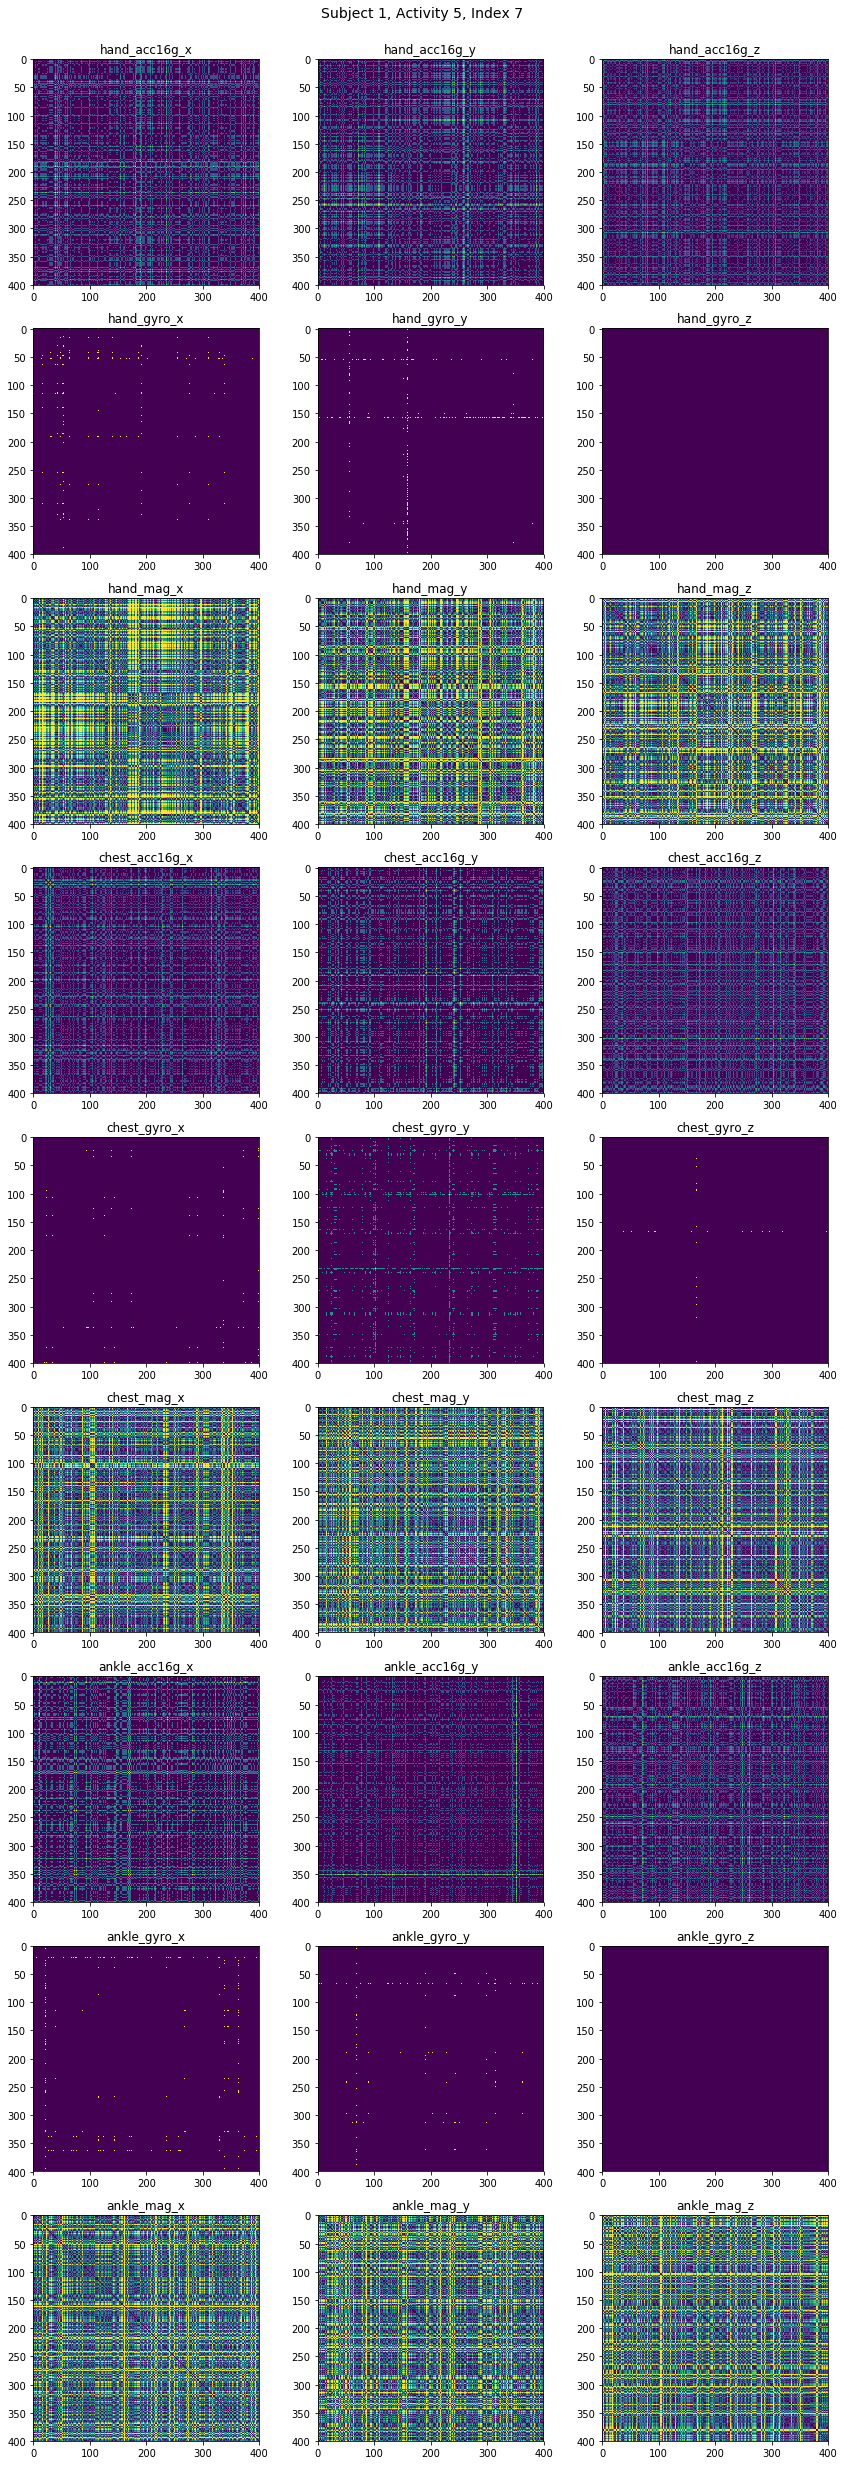

In [146]:
sub = 1
act = 5
ind = np.random.randint(len(np.where(rawchunks[0][:, 0, 1]==act)[0]))
findex = [4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32]

fig = plt.figure(figsize=[12, 36])
for f in range(len(findex)):
    ax = fig.add_subplot(9, 3, f+1)
    ax.imshow(recurrence_plot(rawchunks[sub-1][ind1,:, findex[f]][:,None]))
    ax.set_title(DP.col_sublabels[findex[f]])
fig.suptitle('Subject '+str(sub)+', Activity '+str(act)+', Index '+str(ind), fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.97]);

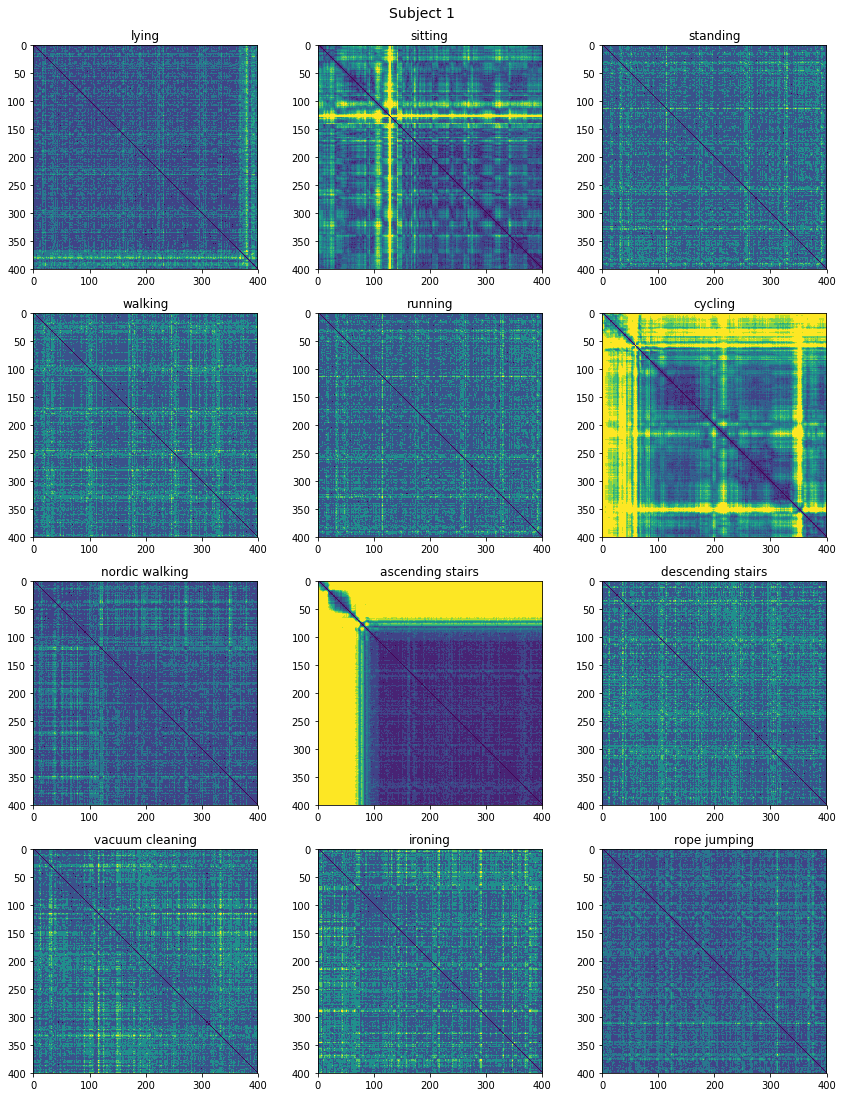

In [165]:
sub = 1
chunkdata = rawnormchunks
acts = np.unique(chunkdata[sub-1][:, 0, 1])
inds = [np.random.randint(len(np.where(chunkdata[sub-1][:, 0, 1]==a)[0])) for a in acts]
# findex = [4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32]

fig = plt.figure(figsize=[12, 16])
for i in range(len(acts)):
    ax = fig.add_subplot(4, 3, i+1)
    ax.imshow(recurrence_plot(chunkdata[sub-1][inds[i],:,3:]))
    ax.set_title(DP.activity_dict[acts[i]])
fig.suptitle('Subject '+str(sub), fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.97]);

In [192]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import backend as K
from keras.utils import to_categorical
from keras.utils import np_utils

from keras.utils import to_categorical
from keras.utils import np_utils

#### Prepare trainging and testing chunks of data:

In [218]:
def transform_label(labels):
    unilabels = np.unique(labels)
    D = dict(zip(unilabels, np.linspace(0, len(unilabels)-1, len(unilabels))))
    x = labels.copy()
    for l in unilabels:
        x = np.where(x==l, D[l], x)
    return x

In [171]:
# get rid of timestamp:
for s in range(len(rawchunks)):
    rawchunks[s] = rawchunks[s][:, :, 1:]
    rawnormchunks[s] = rawnormchunks[s][:, :, 1:]

In [245]:
rawdata = np.vstack(rawchunks)
rawnormdata = np.vstack(rawnormchunks)

In [255]:
np.random.shuffle(rawdata)
np.random.shuffle(rawnormdata)

Xraw = rawdata[:,:,1:]
yraw = rawdata[:,0,0]
Xrawnorm = rawnormdata[:,:,1:]
yrawnorm = rawnormdata[:,0,0]

# Reshape chunks:
a,b,c = Xrawnorm.shape
Xraw = Xraw.reshape(a, 1, b, c)
Xrawnorm = Xrawnorm.reshape(a, 1, b, c)

n_act = len(np.unique(yraw))
Yraw = np_utils.to_categorical(transform_label(yraw), n_act)
Yrawnorm = np_utils.to_categorical(transform_label(yrawnorm), n_act)

In [256]:
Xraw_train, Xraw_test, Yraw_train, Yraw_test = train_test_split(Xraw, Yraw, test_size=0.20, random_state=42)
Xrawnorm_train, Xrawnorm_test, Yrawnorm_train, Yrawnorm_test = train_test_split(Xrawnorm, Yrawnorm, test_size=0.20, random_state=42)

## CNN for segment chunks:

In [257]:
model = Sequential()
 
model.add(Conv2D(100, (3, 3), activation='relu', input_shape=(1,400,31), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(100, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Flatten())
model.add(Dense(50, activation='relu'))
#model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.5))
model.add(Dense(n_act, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [258]:
model.fit(Xrawnorm_train, Yrawnorm_train, epochs=25, batch_size=16,shuffle=True)

Epoch 1/25
3418/3418 [==============================] - 548s 160ms/step - loss: 12.6206 - acc: 0.1027
Epoch 2/25
3418/3418 [==============================] - 552s 161ms/step - loss: 1.6624 - acc: 0.4143
Epoch 3/25
3418/3418 [==============================] - 561s 164ms/step - loss: 0.6550 - acc: 0.7659
Epoch 4/25
3418/3418 [==============================] - 554s 162ms/step - loss: 0.3793 - acc: 0.8563
Epoch 5/25
3418/3418 [==============================] - 569s 167ms/step - loss: 0.3101 - acc: 0.8765
Epoch 6/25
3418/3418 [==============================] - 546s 160ms/step - loss: 0.2807 - acc: 0.8935
Epoch 7/25
3418/3418 [==============================] - 544s 159ms/step - loss: 0.2569 - acc: 0.8947
Epoch 8/25
3418/3418 [==============================] - 602s 176ms/step - loss: 0.2209 - acc: 0.9152
Epoch 9/25
3418/3418 [==============================] - 551s 161ms/step - loss: 0.1978 - acc: 0.9222
Epoch 10/25
3418/3418 [==============================] - 559s 164ms/step - loss: 0.2113 - 

In [259]:
loss, acc = model.evaluate(Xrawnorm_test, Yrawnorm_test)

855/855 [==============================] - 67s 78ms/step


In [265]:
print('accuracy=', acc)

accuracy= 0.98596491256
